In [26]:
import configparser
from pathlib import Path
import pandas as pd
import pandas.io.sql as pandasql
from psycopg2 import connect
import numpy
from psycopg2.extras import execute_values
from datetime import datetime
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
CONFIG = configparser.ConfigParser()
CONFIG.read(str(Path.home().joinpath('db.cfg')))
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

# basemap and centreline highway sql for mapping
basemap_query = '''select gis.geopandas_transform(ST_union(geom)) as geom from gis.neighbourhood_boundary'''
basemap = gpd.GeoDataFrame.from_postgis(basemap_query, con, geom_col='geom')
basemap = basemap.to_crs({'init' :'epsg:26917'})

centreline_query = '''select gis.geopandas_transform(ST_linemerge(geom)) as geom 
                    from gis.centreline where fcode_desc in ('Expressway','Expressway Ramp')
                    '''
highway = gpd.GeoDataFrame.from_postgis(centreline_query, con, geom_col='geom')
highway = highway.to_crs({'init' :'epsg:26917'})

centreline_all_query = '''select gis.geopandas_transform(ST_linemerge(geom)) as geom 
                    from gis.centreline where fcode_desc in ('Collector','Collector Ramp','Expressway','Expressway Ramp',
                    'Local','Major Arterial','Major Arterial Ramp','Minor Arterial',
                    'Minor Arterial Ramp','Pending')
                    '''
centreline = gpd.GeoDataFrame.from_postgis(centreline_all_query, con, geom_col='geom')
centreline = centreline.to_crs({'init' :'epsg:26917'})

def make_map(data, basemap_b, centreline_b, highway_b, color, title):
    f, ax = plt.subplots(figsize=(20,20))
    if basemap_b == True:
        basemap.plot(ax=ax, color = 'grey', alpha=0.2)
    if centreline_b == True:
        centreline.plot(ax=ax, color = 'white', alpha=0.2)
    if highway_b == True:
        highway.plot(ax=ax, color = 'white', alpha=0.2)    
    
    data.plot(column = 'id', ax=ax, cmap=color)
    NUM_COLORS = len(data.col.unique())
    cm = plt.get_cmap(color)
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    handles, labels = [], []

    legend_id = data.col.unique()
    for i in range(0, NUM_COLORS):
        label_name = legend_id[i]
        handles.append(mpl.patches.Patch(color=colors[i],label=label_name))
    ax.legend(handles=handles,loc='lower right', ncol=1, title = title)    
    ax.set_axis_off()

# Corridor Aggregation

## AM Peak

### Q1 (Jan- Mar)

/home/natalie/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


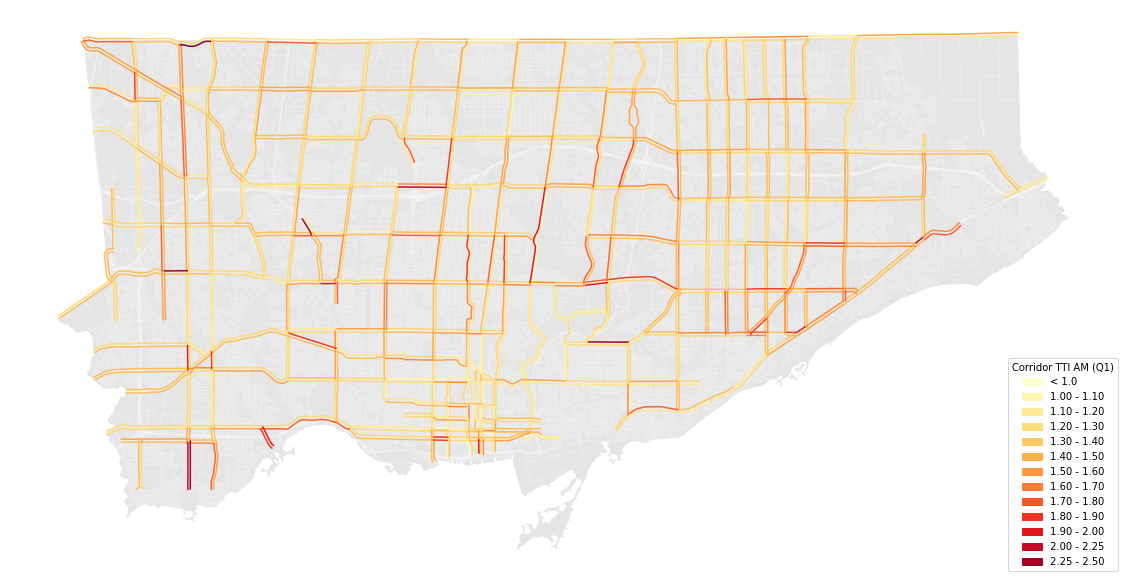

In [49]:
corridor_tti_am_q1 = '''with temp as (
	select segment_id, avg(tti_corr) as avg_tti, st_length(ST_Transform(geom, 98012))as alength 
	from congestion.metrics_v5_2019_q1
	inner join congestion.segments_v5 using (segment_id)
	where time_bin <@ '[07:00:00, 10:00:00)'::timerange 
	group by segment_id, alength
	order by segment_id)
, avged as (
	select distinct corridor_id, segment_id, avg_tti, temp.alength as seg_length, (avg_tti*temp.alength) as avged, 
	cor.length as cor_length, cor.geom as cor_geom
	from temp
	inner join (
		select corridor_id, segment_id
		from congestion.corridors_v1_merged_lookup group by corridor_id, segment_id) corridor using (segment_id)
	inner join congestion.corridors_v1_merged cor using (corridor_id)
	order by corridor_id)
, fin as (
	select corridor_id, sum(avged)/cor_length as tti, cor_geom, cor_length, sum(seg_length) as seg_length
	from avged
	group by corridor_id, cor_geom, cor_length
	order by tti desc)
select corridor_id,  col, id, gis.geopandas_transform(st_offsetcurve(cor_geom, -0.0006)) as geom from fin
right join (select row_number() over () as id, col, range from congestion.colour_range )b on tti::numeric <@ range
where cor_length*0.8 < seg_length and ST_astext(st_offsetcurve(((st_linemerge(cor_geom))), -0.0006)) != 'LINESTRING EMPTY' and ST_geometrytype(cor_geom) = 'ST_LineString'

order by id'''

corridor_tti_am_q1 = gpd.GeoDataFrame.from_postgis(corridor_tti_am_q1, con, geom_col='geom')
corridor_tti_am_q1 = corridor_tti_am_q1.to_crs({'init' :'epsg:26917'})
make_map(corridor_tti_am_q1, True, True, False, 'YlOrRd', 'Corridor TTI AM (Q1)')


### Q2 (Apr- Jun)

/home/natalie/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


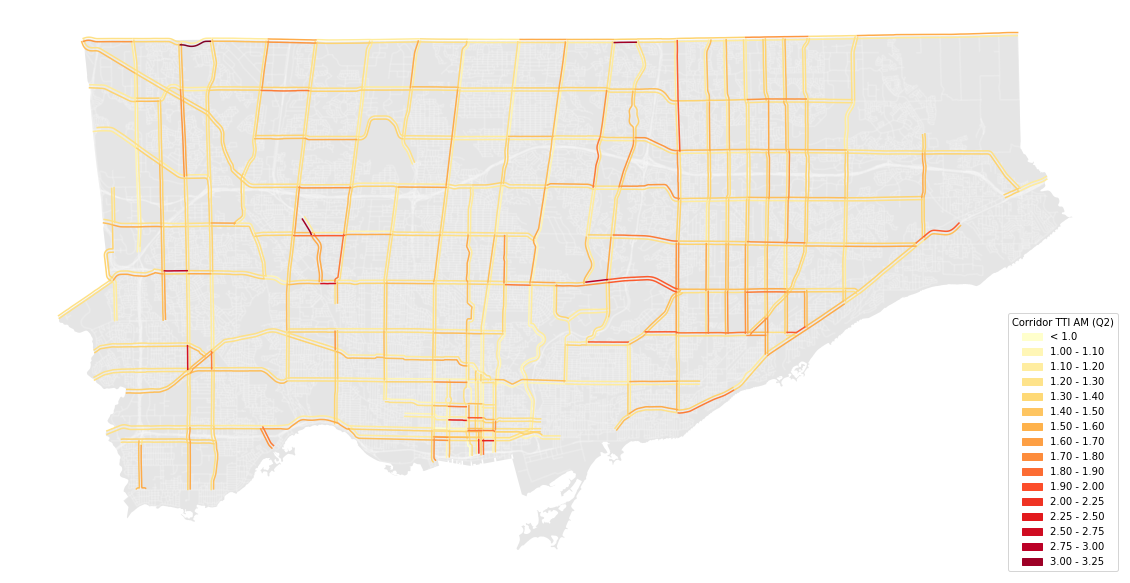

In [48]:
corridor_tti_am_q2 = '''with temp as (
	select segment_id, avg(tti_corr) as avg_tti, st_length(ST_Transform(geom, 98012))as alength 
	from congestion.metrics_v5_2019_q2
	inner join congestion.segments_v5 using (segment_id)
	where time_bin <@ '[07:00:00, 10:00:00)'::timerange 
	group by segment_id, alength
	order by segment_id)
, avged as (
	select distinct corridor_id, segment_id, avg_tti, temp.alength as seg_length, (avg_tti*temp.alength) as avged, 
	cor.length as cor_length, cor.geom as cor_geom
	from temp
	inner join (
		select corridor_id, segment_id
		from congestion.corridors_v1_merged_lookup group by corridor_id, segment_id) corridor using (segment_id)
	inner join congestion.corridors_v1_merged cor using (corridor_id)
	order by corridor_id)
, fin as (
	select corridor_id, sum(avged)/cor_length as tti, cor_geom, cor_length, sum(seg_length) as seg_length
	from avged
	group by corridor_id, cor_geom, cor_length
	order by tti desc)
select corridor_id,  col, id, gis.geopandas_transform(st_offsetcurve(cor_geom, -0.0006)) as geom from fin
right join (select row_number() over () as id, col, range from congestion.colour_range )b on tti::numeric <@ range
where cor_length*0.8 < seg_length and ST_astext(st_offsetcurve(((st_linemerge(cor_geom))), -0.0006)) != 'LINESTRING EMPTY' and ST_geometrytype(cor_geom) = 'ST_LineString'

order by id'''

corridor_tti_am_q2 = gpd.GeoDataFrame.from_postgis(corridor_tti_am_q2, con, geom_col='geom')
corridor_tti_am_q2 = corridor_tti_am_q2.to_crs({'init' :'epsg:26917'})
make_map(corridor_tti_am_q2, True, True, False, 'YlOrRd', 'Corridor TTI AM (Q2)')


### Q3 (Jul- Sep)

/home/natalie/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


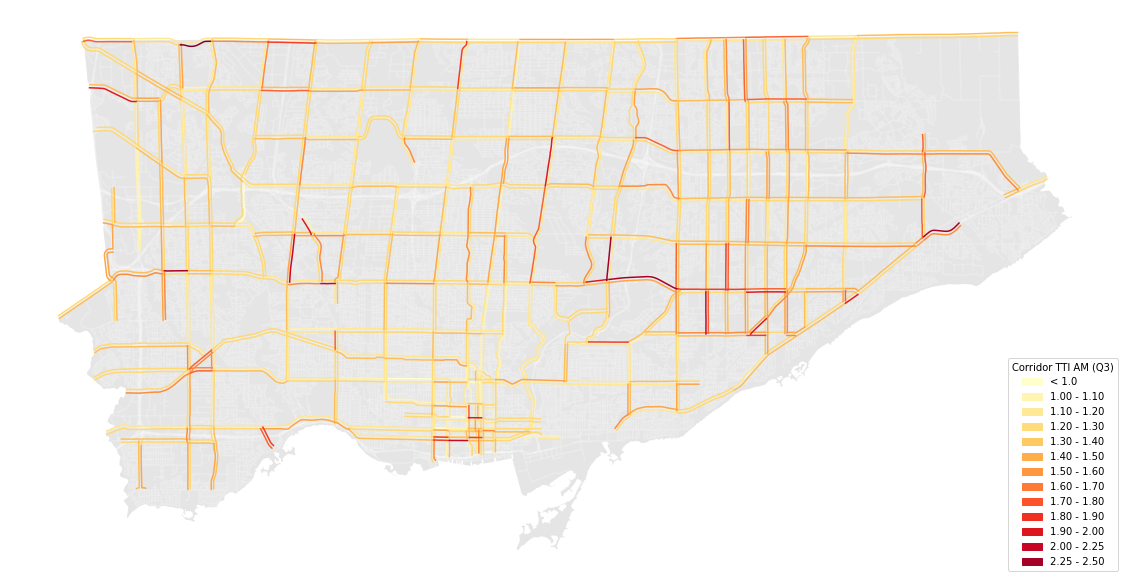

In [47]:
corridor_tti_am_q3 = '''with temp as (
	select segment_id, avg(tti_corr) as avg_tti, st_length(ST_Transform(geom, 98012))as alength 
	from congestion.metrics_v5_2019_q3
	inner join congestion.segments_v5 using (segment_id)
	where time_bin <@ '[07:00:00, 10:00:00)'::timerange 
	group by segment_id, alength
	order by segment_id)
, avged as (
	select distinct corridor_id, segment_id, avg_tti, temp.alength as seg_length, (avg_tti*temp.alength) as avged, 
	cor.length as cor_length, cor.geom as cor_geom
	from temp
	inner join (
		select corridor_id, segment_id
		from congestion.corridors_v1_merged_lookup group by corridor_id, segment_id) corridor using (segment_id)
	inner join congestion.corridors_v1_merged cor using (corridor_id)
	order by corridor_id)
, fin as (
	select corridor_id, sum(avged)/cor_length as tti, cor_geom, cor_length, sum(seg_length) as seg_length
	from avged
	group by corridor_id, cor_geom, cor_length
	order by tti desc)
select corridor_id,  col, id, gis.geopandas_transform(st_offsetcurve(cor_geom, -0.0006)) as geom from fin
right join (select row_number() over () as id, col, range from congestion.colour_range )b on tti::numeric <@ range
where cor_length*0.8 < seg_length and ST_astext(st_offsetcurve(((st_linemerge(cor_geom))), -0.0006)) != 'LINESTRING EMPTY' and ST_geometrytype(cor_geom) = 'ST_LineString'

order by id'''

corridor_tti_am_q3 = gpd.GeoDataFrame.from_postgis(corridor_tti_am_q3, con, geom_col='geom')
corridor_tti_am_q3 = corridor_tti_am_q3.to_crs({'init' :'epsg:26917'})
make_map(corridor_tti_am_q3, True, True, False, 'YlOrRd', 'Corridor TTI AM (Q3)')


### Q4 (Oct - Dec)

/home/natalie/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


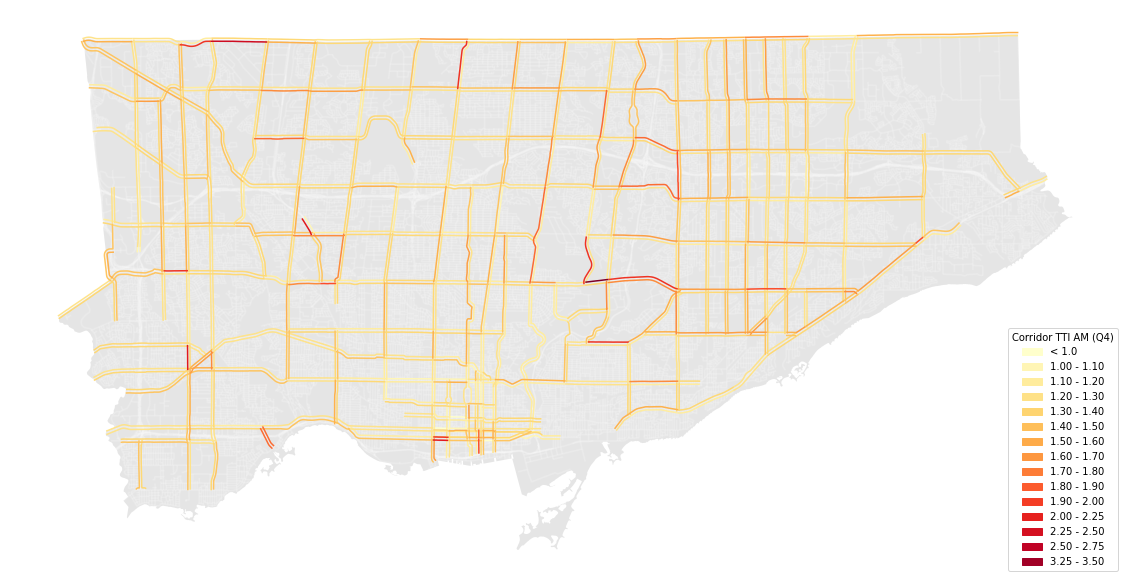

In [44]:
corridor_tti_am_q4 = '''with temp as (
	select segment_id, avg(tti_corr) as avg_tti, st_length(ST_Transform(geom, 98012))as alength 
	from congestion.metrics_v5_2019_q4
	inner join congestion.segments_v5 using (segment_id)
	where time_bin <@ '[07:00:00, 10:00:00)'::timerange 
	group by segment_id, alength
	order by segment_id)
, avged as (
	select distinct corridor_id, segment_id, avg_tti, temp.alength as seg_length, (avg_tti*temp.alength) as avged, 
	cor.length as cor_length, cor.geom as cor_geom
	from temp
	inner join (
		select corridor_id, segment_id
		from congestion.corridors_v1_merged_lookup group by corridor_id, segment_id) corridor using (segment_id)
	inner join congestion.corridors_v1_merged cor using (corridor_id)
	order by corridor_id)
, fin as (
	select corridor_id, sum(avged)/cor_length as tti, cor_geom, cor_length, sum(seg_length) as seg_length
	from avged
	group by corridor_id, cor_geom, cor_length
	order by tti desc)
select corridor_id,  col, id, gis.geopandas_transform(st_offsetcurve(cor_geom, -0.0006)) as geom from fin
right join (select row_number() over () as id, col, range from congestion.colour_range )b on tti::numeric <@ range
where cor_length*0.8 < seg_length and ST_astext(st_offsetcurve(((st_linemerge(cor_geom))), -0.0006)) != 'LINESTRING EMPTY' and ST_geometrytype(cor_geom) = 'ST_LineString'

order by id'''

corridor_tti_am_q4 = gpd.GeoDataFrame.from_postgis(corridor_tti_am_q4, con, geom_col='geom')
corridor_tti_am_q4 = corridor_tti_am_q4.to_crs({'init' :'epsg:26917'})
make_map(corridor_tti_am_q4, True, True, False, 'YlOrRd', 'Corridor TTI AM (Q4)')


## PM Peak

## Q1 (Jan - Mar)

/home/natalie/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


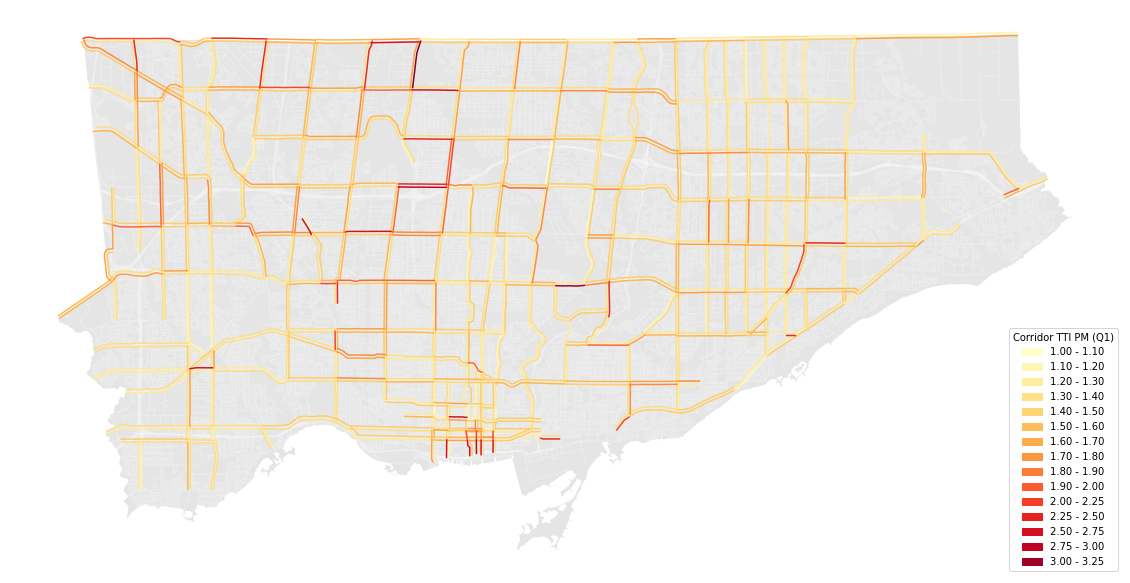

In [54]:
corridor_tti_pm_q1 = '''with temp as (
	select segment_id, avg(tti_corr) as avg_tti, st_length(ST_Transform(geom, 98012))as alength 
	from congestion.metrics_v5_2019_q1
	inner join congestion.segments_v5 using (segment_id)
	where time_bin <@ '[16:00:00, 19:00:00)'::timerange 
	group by segment_id, alength
	order by segment_id)
, avged as (
	select distinct corridor_id, segment_id, avg_tti, temp.alength as seg_length, (avg_tti*temp.alength) as avged, 
	cor.length as cor_length, cor.geom as cor_geom
	from temp
	inner join (
		select corridor_id, segment_id
		from congestion.corridors_v1_merged_lookup group by corridor_id, segment_id) corridor using (segment_id)
	inner join congestion.corridors_v1_merged cor using (corridor_id)
	order by corridor_id)
, fin as (
	select corridor_id, sum(avged)/cor_length as tti, cor_geom, cor_length, sum(seg_length) as seg_length
	from avged
	group by corridor_id, cor_geom, cor_length
	order by tti desc)
select corridor_id,  col, id, gis.geopandas_transform(st_offsetcurve(cor_geom, -0.0006)) as geom from fin
right join (select row_number() over () as id, col, range from congestion.colour_range )b on tti::numeric <@ range
where cor_length*0.8 < seg_length and ST_astext(st_offsetcurve(((st_linemerge(cor_geom))), -0.0006)) != 'LINESTRING EMPTY' and ST_geometrytype(cor_geom) = 'ST_LineString'

order by id'''

corridor_tti_pm_q1 = gpd.GeoDataFrame.from_postgis(corridor_tti_pm_q1, con, geom_col='geom')
corridor_tti_pm_q1 = corridor_tti_pm_q1.to_crs({'init' :'epsg:26917'})
make_map(corridor_tti_pm_q1, True, True, False, 'YlOrRd', 'Corridor TTI PM (Q1)')


## Q2 (Apr - Jun)

/home/natalie/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


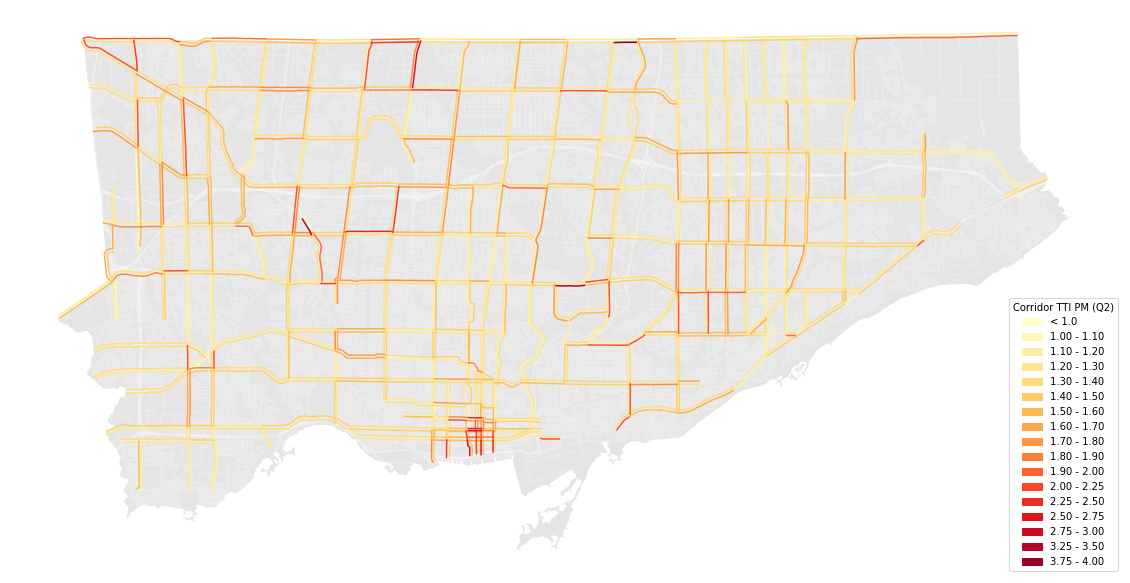

In [51]:
corridor_tti_pm_q2 = '''with temp as (
	select segment_id, avg(tti_corr) as avg_tti, st_length(ST_Transform(geom, 98012))as alength 
	from congestion.metrics_v5_2019_q2
	inner join congestion.segments_v5 using (segment_id)
	where time_bin <@ '[16:00:00, 19:00:00)'::timerange 
	group by segment_id, alength
	order by segment_id)
, avged as (
	select distinct corridor_id, segment_id, avg_tti, temp.alength as seg_length, (avg_tti*temp.alength) as avged, 
	cor.length as cor_length, cor.geom as cor_geom
	from temp
	inner join (
		select corridor_id, segment_id
		from congestion.corridors_v1_merged_lookup group by corridor_id, segment_id) corridor using (segment_id)
	inner join congestion.corridors_v1_merged cor using (corridor_id)
	order by corridor_id)
, fin as (
	select corridor_id, sum(avged)/cor_length as tti, cor_geom, cor_length, sum(seg_length) as seg_length
	from avged
	group by corridor_id, cor_geom, cor_length
	order by tti desc)
select corridor_id,  col, id, gis.geopandas_transform(st_offsetcurve(cor_geom, -0.0006)) as geom from fin
right join (select row_number() over () as id, col, range from congestion.colour_range )b on tti::numeric <@ range
where cor_length*0.8 < seg_length and ST_astext(st_offsetcurve(((st_linemerge(cor_geom))), -0.0006)) != 'LINESTRING EMPTY' and ST_geometrytype(cor_geom) = 'ST_LineString'

order by id'''

corridor_tti_pm_q2 = gpd.GeoDataFrame.from_postgis(corridor_tti_pm_q2, con, geom_col='geom')
corridor_tti_pm_q2 = corridor_tti_pm_q2.to_crs({'init' :'epsg:26917'})
make_map(corridor_tti_pm_q2, True, True, False, 'YlOrRd', 'Corridor TTI PM (Q2)')


### Q3 (Jul- Sep)

/home/natalie/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


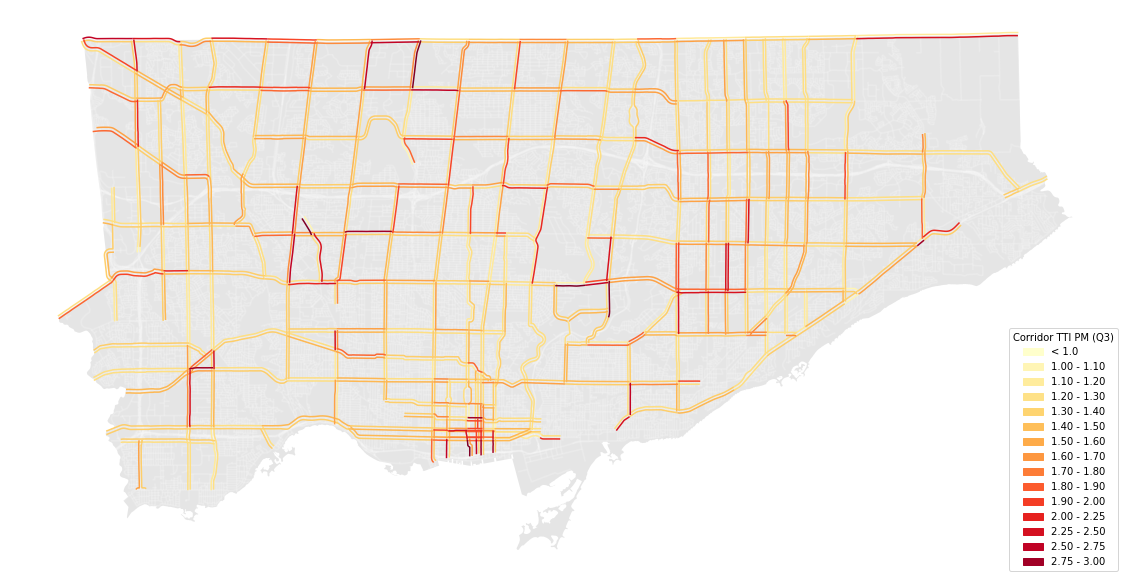

In [52]:
corridor_tti_pm_q3 = '''with temp as (
	select segment_id, avg(tti_corr) as avg_tti, st_length(ST_Transform(geom, 98012))as alength 
	from congestion.metrics_v5_2019_q3
	inner join congestion.segments_v5 using (segment_id)
	where time_bin <@ '[16:00:00, 19:00:00)'::timerange 
	group by segment_id, alength
	order by segment_id)
, avged as (
	select distinct corridor_id, segment_id, avg_tti, temp.alength as seg_length, (avg_tti*temp.alength) as avged, 
	cor.length as cor_length, cor.geom as cor_geom
	from temp
	inner join (
		select corridor_id, segment_id
		from congestion.corridors_v1_merged_lookup group by corridor_id, segment_id) corridor using (segment_id)
	inner join congestion.corridors_v1_merged cor using (corridor_id)
	order by corridor_id)
, fin as (
	select corridor_id, sum(avged)/cor_length as tti, cor_geom, cor_length, sum(seg_length) as seg_length
	from avged
	group by corridor_id, cor_geom, cor_length
	order by tti desc)
select corridor_id,  col, id, gis.geopandas_transform(st_offsetcurve(cor_geom, -0.0006)) as geom from fin
right join (select row_number() over () as id, col, range from congestion.colour_range )b on tti::numeric <@ range
where cor_length*0.8 < seg_length and ST_astext(st_offsetcurve(((st_linemerge(cor_geom))), -0.0006)) != 'LINESTRING EMPTY' and ST_geometrytype(cor_geom) = 'ST_LineString'

order by id'''

corridor_tti_pm_q3 = gpd.GeoDataFrame.from_postgis(corridor_tti_pm_q3, con, geom_col='geom')
corridor_tti_pm_q3 = corridor_tti_pm_q3.to_crs({'init' :'epsg:26917'})
make_map(corridor_tti_pm_q3, True, True, False, 'YlOrRd', 'Corridor TTI PM (Q3)')


### Q4 (Oct - Dec)

/home/natalie/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


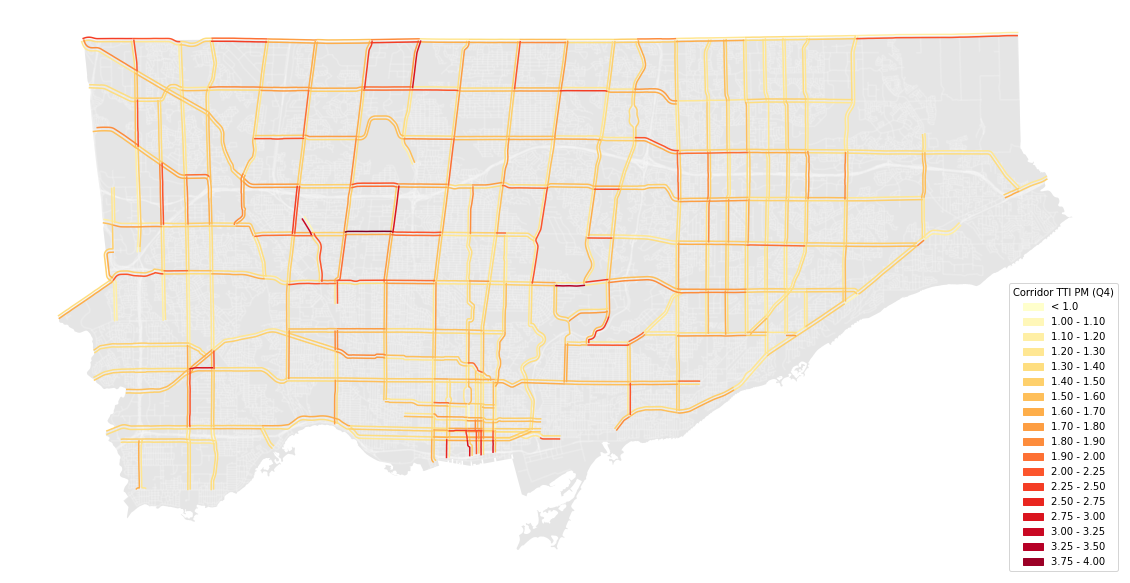

In [53]:
corridor_tti_pm_q4 = '''with temp as (
	select segment_id, avg(tti_corr) as avg_tti, st_length(ST_Transform(geom, 98012))as alength 
	from congestion.metrics_v5_2019_q4
	inner join congestion.segments_v5 using (segment_id)
	where time_bin <@ '[16:00:00, 19:00:00)'::timerange 
	group by segment_id, alength
	order by segment_id)
, avged as (
	select distinct corridor_id, segment_id, avg_tti, temp.alength as seg_length, (avg_tti*temp.alength) as avged, 
	cor.length as cor_length, cor.geom as cor_geom
	from temp
	inner join (
		select corridor_id, segment_id
		from congestion.corridors_v1_merged_lookup group by corridor_id, segment_id) corridor using (segment_id)
	inner join congestion.corridors_v1_merged cor using (corridor_id)
	order by corridor_id)
, fin as (
	select corridor_id, sum(avged)/cor_length as tti, cor_geom, cor_length, sum(seg_length) as seg_length
	from avged
	group by corridor_id, cor_geom, cor_length
	order by tti desc)
select corridor_id,  col, id, gis.geopandas_transform(st_offsetcurve(cor_geom, -0.0006)) as geom from fin
right join (select row_number() over () as id, col, range from congestion.colour_range )b on tti::numeric <@ range
where cor_length*0.8 < seg_length and ST_astext(st_offsetcurve(((st_linemerge(cor_geom))), -0.0006)) != 'LINESTRING EMPTY' and ST_geometrytype(cor_geom) = 'ST_LineString'

order by id'''

corridor_tti_pm_q4 = gpd.GeoDataFrame.from_postgis(corridor_tti_pm_q4, con, geom_col='geom')
corridor_tti_pm_q4 = corridor_tti_pm_q4.to_crs({'init' :'epsg:26917'})
make_map(corridor_tti_pm_q4, True, True, False, 'YlOrRd', 'Corridor TTI PM (Q4)')
